In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path
import os
import zipfile
import random
from PIL import Image
from tqdm.auto import tqdm

###  Setup Device Agnostic Code..

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1 Getting Custom Dataset

* Setup the datapath

In [3]:
data_path=Path("data/")
image_path=data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
   request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
   print("Downloading pizza, steak, sushi data...")
   f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi directory already exists
Unzipping pizza, steak, sushi data...


In [4]:
image_path

PosixPath('data/pizza_steak_sushi')

### 1.1 Setup Training and Test Path

In [5]:
train_dir=image_path / "train"
test_dir=image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###1.2 Visualizing an image

pizza


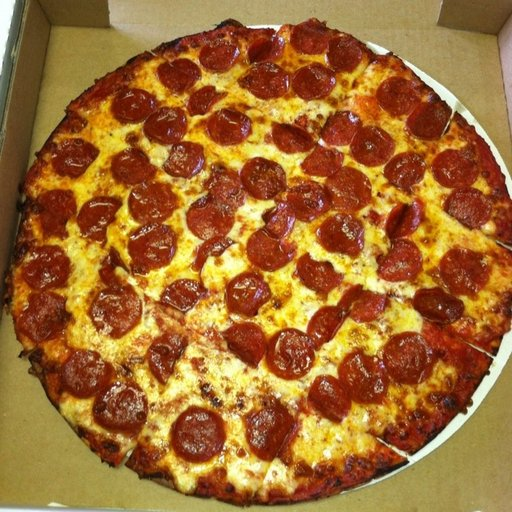

In [6]:
random.seed(42)

image_path_list=list(image_path.glob("*/*/*.jpg"))
random_img_path=random.choice(image_path_list)

image_class=random_img_path.parent.stem
print(image_class)
img=Image.open(random_img_path)
img

(-0.5, 511.5, 511.5, -0.5)

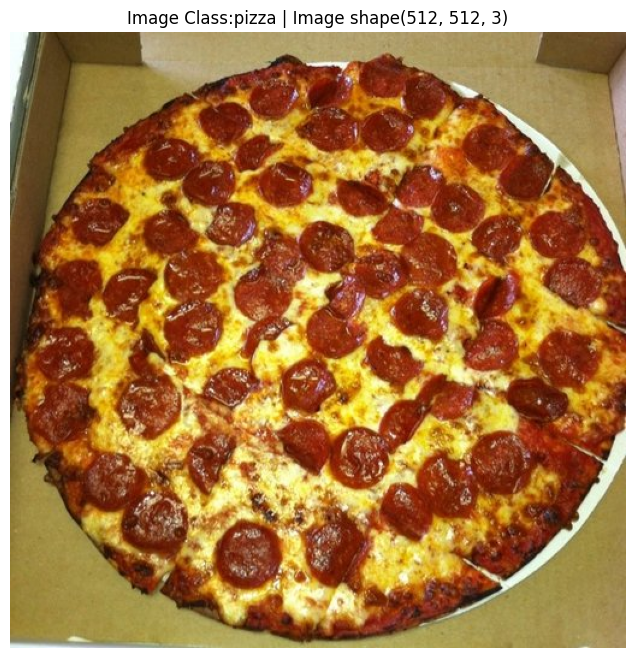

In [7]:
# Turn the image into an array

img_as_array=np.asarray(img)

#plot the image

plt.figure(figsize=(10,8))
plt.imshow(img_as_array)
plt.title(f"Image Class:{image_class} | Image shape{img_as_array.shape}")
plt.axis(False)

## 3. Transforming Data

### 3.1 Transforming data with `torchvision.transforms`

In [8]:
data_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [9]:
data_transform(img)

tensor([[[0.4078, 0.4196, 0.4157,  ..., 0.3569, 0.8157, 0.9647],
         [0.3647, 0.3961, 0.4078,  ..., 0.3373, 0.7373, 0.9608],
         [0.3843, 0.3686, 0.3922,  ..., 0.3412, 0.6235, 0.9529],
         ...,
         [0.6353, 0.6471, 0.6471,  ..., 0.6078, 0.6078, 0.6039],
         [0.6549, 0.6549, 0.6588,  ..., 0.6039, 0.6000, 0.5961],
         [0.6627, 0.6627, 0.6745,  ..., 0.6627, 0.6667, 0.6745]],

        [[0.2980, 0.3020, 0.3098,  ..., 0.3686, 0.8471, 1.0000],
         [0.2588, 0.2824, 0.2980,  ..., 0.3412, 0.7725, 0.9961],
         [0.2784, 0.2588, 0.2824,  ..., 0.3373, 0.6588, 0.9922],
         ...,
         [0.5451, 0.5529, 0.5647,  ..., 0.5333, 0.5255, 0.5137],
         [0.5647, 0.5647, 0.5765,  ..., 0.5412, 0.5333, 0.5255],
         [0.5686, 0.5725, 0.5961,  ..., 0.6627, 0.6745, 0.6824]],

        [[0.1765, 0.1686, 0.1569,  ..., 0.2941, 0.8235, 0.9922],
         [0.1451, 0.1529, 0.1490,  ..., 0.2549, 0.7451, 0.9922],
         [0.1725, 0.1333, 0.1373,  ..., 0.2392, 0.6235, 0.

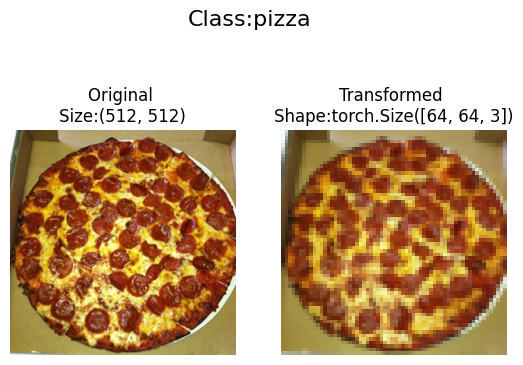

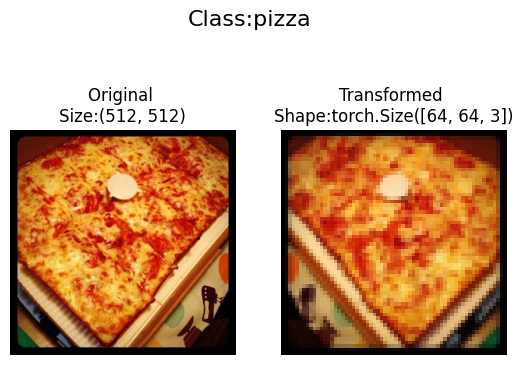

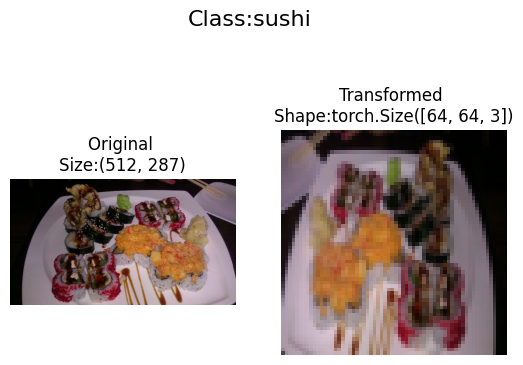

In [10]:
def plot_transformed_image(image_path,transform,n=3,seed=42):
    random.seed(seed)
    random_image_path=random.sample(image_path,k=n)
    for image_path in random_image_path:
      with Image.open(image_path) as f:
        fig,ax=plt.subplots(nrows=1,ncols=2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize:{f.size}")
        ax[0].axis("off")

        transformed_image=transform(f).permute(1,2,0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nShape:{transformed_image.shape}")
        ax[1].axis("off")
        fig.suptitle(f"Class:{image_path.parent.stem}",fontsize=16)


plot_transformed_image(image_path=image_path_list,transform=data_transform)

###4 Option1: Loading image data using `ImageFolder`

In [11]:
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
#Get class names as list

class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data),len(test_data)

(225, 75)

In [15]:
# Index on the train_data Dataset to get a single image and label
img,label=train_data[0][0],train_data[0][1]
img.shape,label


(torch.Size([3, 64, 64]), 0)

In [16]:
class_names[label]

'pizza'

Text(0.5, 1.0, 'pizza')

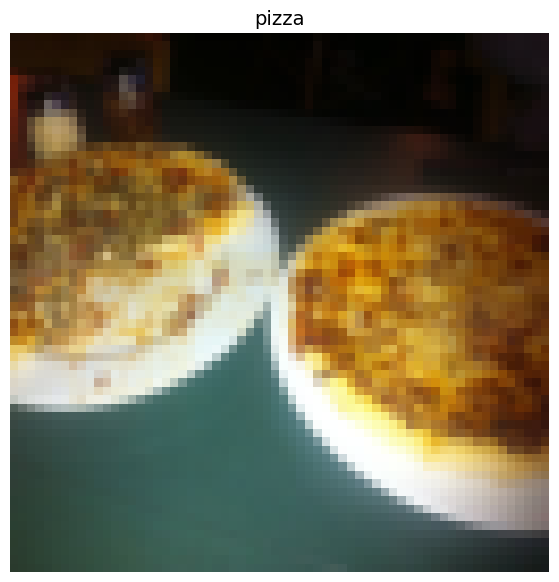

In [17]:
#Rearrange the order dimensions

img_permuted=img.permute(1,2,0)
img_permuted.shape

plt.figure(figsize=(10,7))
plt.imshow(img_permuted)
plt.axis(False)
plt.title(class_names[label],fontsize=14)

###4.1 Turn Dataset into DataLoaders

In [18]:
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader=DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e204a14f940>,
 <torch.utils.data.dataloader.DataLoader at 0x7e204a14f7c0>)

In [19]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [20]:
img,label=next(iter(train_dataloader))
img.shape,label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

###4.2 Create a function to display random images

In [21]:
def display_random_image(dataset,
                         classes,
                         n=10,
                         display_shape=True,
                         seed=None):
  if n>10:
    n=10
    display_shape=False
  if seed:
    random.seed(seed)
  random_sample_idx=random.sample(range(len(dataset)),k=n)
  plt.figure(figsize=(16,8))
  for i , targ_sample in enumerate(random_sample_idx):
    targ_img,label=dataset[targ_sample][0],dataset[targ_sample][1]
    targ_img_adjust=targ_img.permute(1,2,0)
    plt.subplot(1,n,i+1)
    plt.imshow(targ_img_adjust)
    plt.axis("off")
    if classes:
      title=f"Class:{classes[label]}"
      if display_shape:
        title=title+f"\nShape:{targ_img.shape}"
      plt.title(title)
  plt.show()


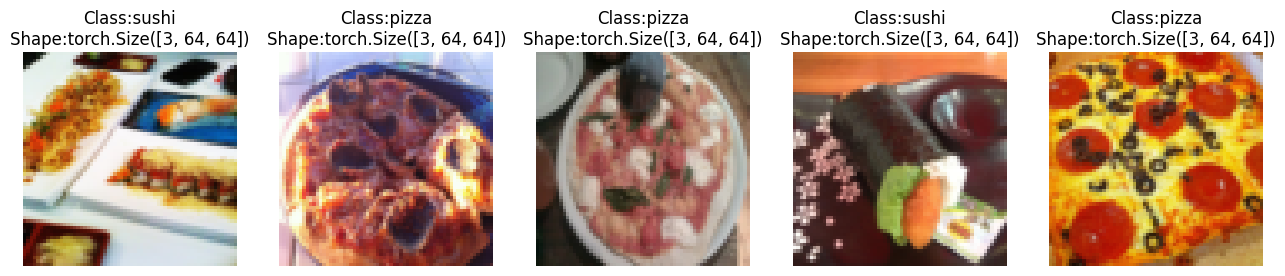

In [22]:
display_random_image(dataset=train_data,
                     classes=class_names,
                     n=5,
                     seed=42)

##5. Other forms of Transforms(data augmentation)

In [23]:
train_transform=transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()
])

test_transform=transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
])

train_transform,test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

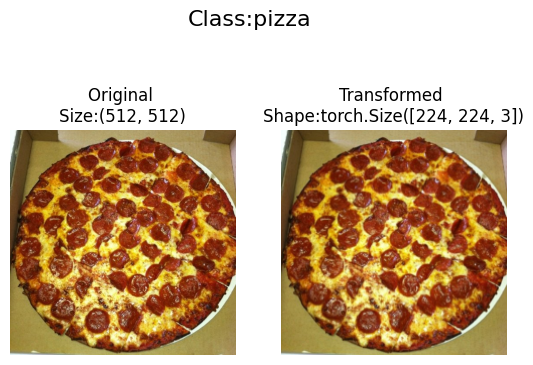

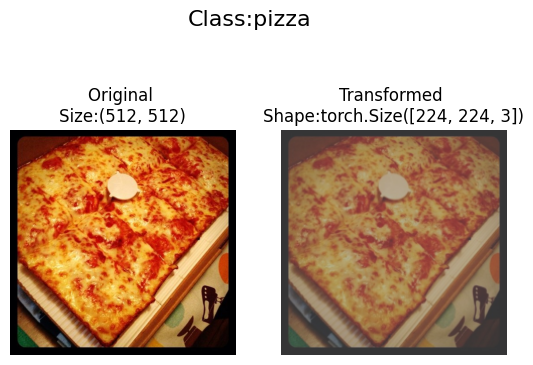

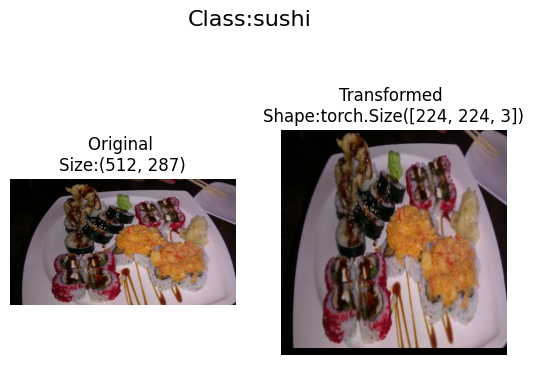

In [24]:
#plot random transformed images

plot_transformed_image(image_path=image_path_list,
                       transform=train_transform)

##6. Model 0: TinyVGG without data augmentation

### 6.1 Creating transforms and loading data for Model 0

In [25]:
# Create simple transform

simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [26]:
#1. Load and transform data

train_data_simple=datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform,
                                        target_transform=None)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

#2. Tur dataset into dataloader

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7e2047405930>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2047417d90>)

###6.2 Create TinyVGG Model Class

In [27]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x=self.conv_block_1(x)
   # print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x



In [28]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

###6.3 Try a forward pass on a single image

In [29]:
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [30]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

###6.4 Use `torchinfo` to get an idea of the shapes going through our Model

In [31]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torch

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

###6.5 Create train and test loops functions

In [32]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
  model.train()
  train_loss,train_acc=0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    y_pred=model(X)

    loss=loss_fn(y_pred,y)

    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss,train_acc



In [33]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device:torch.device):
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)

      test_pred=model(X)

      loss=loss_fn(test_pred,y)

      test_loss+=loss.item()

      test_pred_class=test_pred.argmax(dim=1)

      test_acc+=(test_pred_class==y).sum().item()/len(test_pred_class)

  test_loss=test_loss/len(dataloader)

  test_acc=test_acc/len(dataloader)

  return test_loss,test_acc


In [34]:
def train(model:nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.Module,
          epochs:int,
          device:torch.device):
  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)
    print(
        f"Epoch:{epoch+1} | Train_loss:{train_loss:.4f} | Train_acc:{train_acc:.4f} | Test_loss:{test_loss:.4f} | Test_acc:{test_acc:.4f}"
    )
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results


### 6.7 Train and evaluate model 0

In [35]:
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

optimizer=torch.optim.Adam(params=model_0.parameters(),lr=0.001)

loss_fn=nn.CrossEntropyLoss()

NUM_EPOCHS=10
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1 | Train_loss:1.1035 | Train_acc:0.2500 | Test_loss:1.0993 | Test_acc:0.2604
Epoch:2 | Train_loss:1.0761 | Train_acc:0.4258 | Test_loss:1.1300 | Test_acc:0.2604
Epoch:3 | Train_loss:1.0724 | Train_acc:0.4258 | Test_loss:1.1622 | Test_acc:0.2604
Epoch:4 | Train_loss:1.1099 | Train_acc:0.3047 | Test_loss:1.1516 | Test_acc:0.2708
Epoch:5 | Train_loss:1.0834 | Train_acc:0.3555 | Test_loss:1.1496 | Test_acc:0.2396
Epoch:6 | Train_loss:1.0863 | Train_acc:0.4180 | Test_loss:1.1329 | Test_acc:0.3125
Epoch:7 | Train_loss:0.9935 | Train_acc:0.5742 | Test_loss:1.1207 | Test_acc:0.2812
Epoch:8 | Train_loss:0.9949 | Train_acc:0.5312 | Test_loss:1.0643 | Test_acc:0.3116
Epoch:9 | Train_loss:0.9873 | Train_acc:0.4648 | Test_loss:1.0224 | Test_acc:0.3513
Epoch:10 | Train_loss:0.8765 | Train_acc:0.4961 | Test_loss:0.9383 | Test_acc:0.5663


###6.8 Plot The loss curves

In [36]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [37]:
def plot_loss_curves(results):
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]
  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()


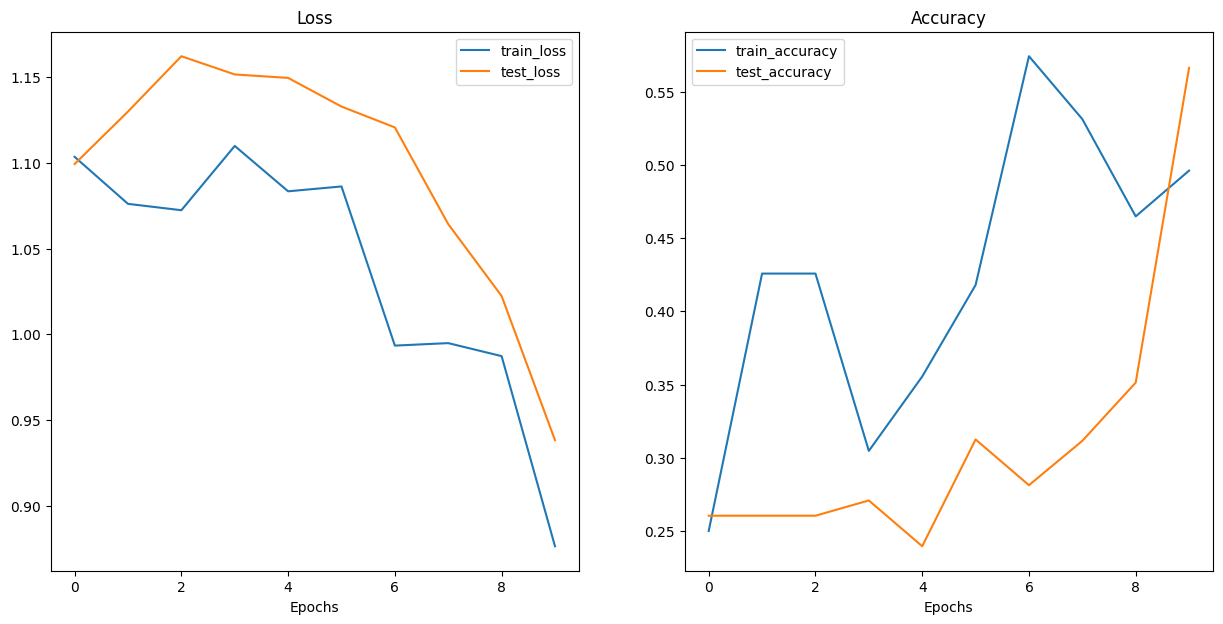

In [38]:
plot_loss_curves(model_0_results)

##7 Model 1: TinyVGG with Data Augmentation

### 7.1 Create transform with Data Augmentation

In [39]:
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_transform_trivial,test_transform_trivial

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

###7.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [40]:
train_data_augment=datasets.ImageFolder(root=train_dir,
                                         transform=train_transform_trivial,
                                         target_transform=None)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_trivial)
train_data_augment,test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [41]:
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_augment=DataLoader(dataset=train_data_augment,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_augment,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7e20472527a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2047251450>)

###7.3 Construct and train model 1

In [42]:
torch.manual_seed(42)

model_1=TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=len(train_data_augment.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [43]:
torch.manual_seed(42)

NUM_EPOCHS=5

optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

loss_fn=nn.CrossEntropyLoss()

model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augment,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | Train_loss:1.1049 | Train_acc:0.2500 | Test_loss:1.1019 | Test_acc:0.2604
Epoch:2 | Train_loss:1.0807 | Train_acc:0.4258 | Test_loss:1.1261 | Test_acc:0.2604
Epoch:3 | Train_loss:1.0712 | Train_acc:0.4258 | Test_loss:1.1593 | Test_acc:0.2604
Epoch:4 | Train_loss:1.1253 | Train_acc:0.3047 | Test_loss:1.1581 | Test_acc:0.2604
Epoch:5 | Train_loss:1.0865 | Train_acc:0.4258 | Test_loss:1.1554 | Test_acc:0.3333


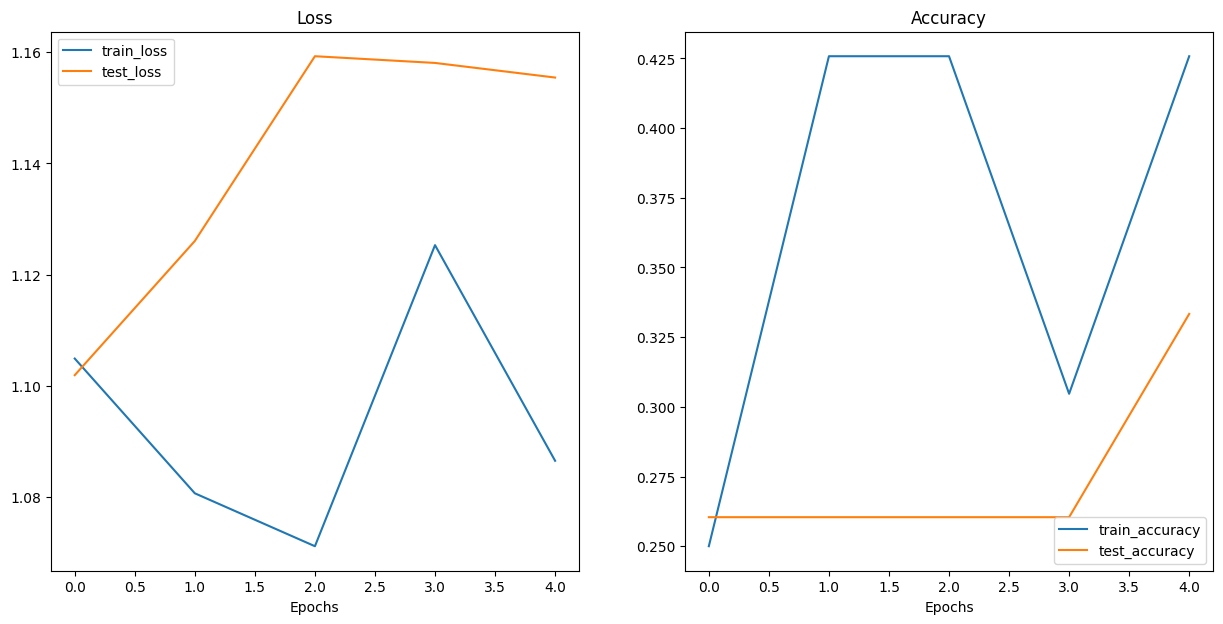

In [44]:
plot_loss_curves(model_1_results)

##8. Making a prediction on a custom image

In [45]:
custom_image_path= data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")


data/04-pizza-dad.jpeg already exists


###8.1 Loading in a custom image with PyTorch

In [46]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
print(f"custom_image_uint8.shape:{custom_image_uint8.shape}")
print(f"custom_image_uint8.dtype:{custom_image_uint8.dtype}")

custom_image_uint8.shape:torch.Size([3, 4032, 3024])
custom_image_uint8.dtype:torch.uint8


###8.2 Making a prediction on a custom image with a trained PyTorch Model

In [47]:
# Load in the custom iamge and convert to torch.float32
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32) /255.

In [48]:
custom_image.dtype

torch.float32

In [49]:
# Create transform to resize our image
custom_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),

])

custom_image_transformed=custom_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

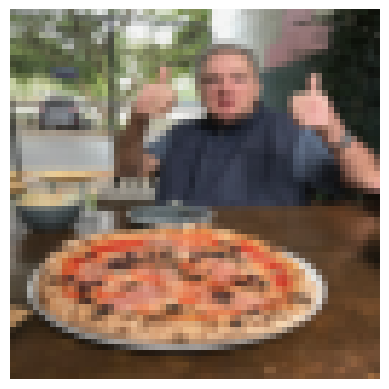

In [50]:
plt.imshow(custom_image_transformed.permute(1,2,0))
plt.axis("off")
plt.show()

In [51]:
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [52]:
model_1.eval()
with torch.inference_mode():
  custom_pred=model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_pred

tensor([[ 0.0781,  0.0379, -0.2067]])

In [53]:
class_names[custom_pred.argmax(dim=1)]

'pizza'

In [54]:
custom_image_pred_prob=torch.softmax(custom_pred,dim=1)
custom_image_pred_prob

tensor([[0.3686, 0.3541, 0.2773]])

In [55]:
custom_image_pred_label=torch.argmax(custom_image_pred_prob,dim=1).cpu()
custom_image_pred_label

tensor([0])

In [56]:
class_names[custom_image_pred_label]

'pizza'

###8.3 Putting custom image prediction togather:building a function

In [71]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names,
                        transform,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    # Instead of passing the transformed image, pass the transformation pipeline directly
    if transform is not None and callable(transform):
        target_image = transform(target_image)
    else:  # Apply a default resize if no transform is provided
        transform = transforms.Compose([
            transforms.Resize(size=(64, 64))
        ])
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

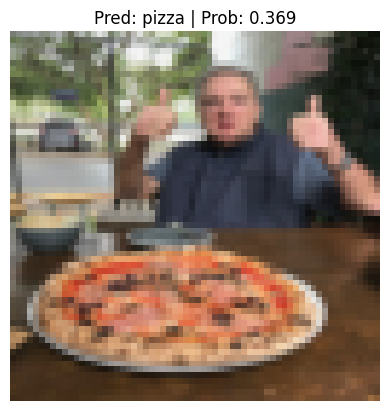

In [74]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transformed,
                    device=device)